# Importing Libraries

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from PIL import Image 
from sklearn.preprocessing import OneHotEncoder
import cv2
import torch
import torch.nn as nn
from torch import optim
#import dlib
#from imutils.face_utils import FaceAligner
#from imutils.face_utils import rect_to_bb
from tqdm import tqdm_notebook 
import math
import scipy
import time
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import string
from google.colab import files
from sklearn.utils import shuffle
np.random.seed(0)

# Functions Definitions

In [0]:
DEPTH = 2 ** 8

def hist_equalization(arr, depth=DEPTH):
  vals, pdf = np.unique(arr, return_counts=True)
  cdf = np.cumsum(pdf)
  min_cdf = min(cdf)
  new_vals = (
      np.round((cdf - min_cdf) / (arr.size - min_cdf) * (depth - 1))
      .astype(int))
  result = np.empty_like(arr)
  for i, val in enumerate(vals):
      result[np.nonzero(arr == val)] = new_vals[i]
  return result

def generate_distorted_image(temp,h,w,j):
  new_img = Image.fromarray(temp*(1 + noise_level*((-1)**j)*np.random.randn(h,w)))
  gray_new_img = np.array(new_img.rotate(np.random.randn()*((-1)**j)*5))

  for l in range(gray_new_img.shape[0]):
    if(gray_new_img[i][0] == 0):
      ctr = 0
      while(np.allclose(gray_new_img[l][ctr],0)):
        ctr += 1
      gray_new_img[l][0:ctr] = np.ones(gray_new_img[l][0:ctr].size)*gray_new_img[l][ctr]
    if(gray_new_img[l][-1] == 0):
      ctr = 0
      while(np.allclose(gray_new_img[l][-1-ctr],0)):
        ctr += 1
      gray_new_img[l][gray_new_img.shape[1]-ctr:] = np.ones(gray_new_img[l][gray_new_img.shape[1]-ctr:].size)*gray_new_img[l][-1-ctr]  
  
  gray_new_img = hist_equalization(gray_new_img)
  return gray_new_img

  
def FAR_FNR(y_hat,y):
  fpr, tpr, thresholds = metrics.roc_curve(y, y_hat)
  fnr = 1-tpr
  return fpr, fnr

def detect_faces(cascade, test_image, scaleFactor = 1.1, minNeighbors= 1):
  # create a copy of the image to prevent any changes to the original one.
  image_copy = test_image.copy()
  
  #convert the test image to gray scale as opencv face detector expects gray images
  gray_image = cv2.cvtColor(image_copy, cv2.COLOR_RGB2GRAY)
  
  # Applying the haar classifier to detect faces
  faces_rect = cascade.detectMultiScale(gray_image, scaleFactor=scaleFactor, minNeighbors=5)
  
  for (x, y, w, h) in faces_rect:
    cv2.rectangle(image_copy, (x, y), (x+w, y+h), (0, 255, 0), 2)
      
  return image_copy, faces_rect

def cropper(im, w, h):
  width, height = im.shape[0], im.shape[1]
  
  left = (width - w)//2
  top = (height - h)//2
  right = (width + w)//2
  bottom = (height + h)//2

  return im[top:bottom, left:right]

def get_cropped_faces(cascade, test_file_names, path, crop_dims=[24,120,16,112], w=128, h=128, scaleFactor = 1.1, minNeighbors=1):
  test_images = np.zeros(h*w)
  for i in range(len(test_file_names)):
    im = np.array(Image.open(path+"{}".format(test_file_names[i])))

    # Converting to grayscale as opencv expects detector takes in input gray scale images
    #gray_image = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
    #faces_rect = cascade.detectMultiScale(gray_image, scaleFactor=scaleFactor, minNeighbors=minNeighbors)
    faces_rect = cascade.detectMultiScale(im, scaleFactor=scaleFactor, minNeighbors=minNeighbors)

    for (x, y, _w, _h) in faces_rect:
      crop_im = im[y:y+_h, x:x+_w]
      crop_im = cv2.resize(crop_im, (w,h), interpolation = cv2.INTER_AREA)
      crop_im = crop_im[crop_dims[0]:crop_dims[1],crop_dims[2]:crop_dims[3]]
      crop_im = cv2.resize(crop_im, (w,h), interpolation = cv2.INTER_AREA)
      crop_im = hist_equalizer(crop_im)
      crop_im = cv2.cvtColor(crop_im, cv2.COLOR_RGB2GRAY)
      temp = np.array(crop_im)
      
      test_images = np.row_stack((test_images,temp.ravel()))
    
  return test_images[1:]
  
"""It helps visualising the portraits from the dataset."""
def plot_portraits(images, h, w, n_row, n_col,save_fig=False,save_dir='Output-images/',save_name='Eigen_faces'):
    plt.figure(figsize=(2.2 * n_col, 2.2 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.20)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.xticks(())
        plt.yticks(())
    if(save_fig):
      plt.savefig(save_dir+save_name+'.png')

def pca(X, n_pc):
    n_samples, n_features = X.shape
    mean = np.mean(X, axis=0)
    centered_data = X-mean
    U, S, V = np.linalg.svd(centered_data)
    components = V[:n_pc]
    projected = U[:,:n_pc]*S[:n_pc]
    print(U[:,:n_pc].shape, S[:n_pc].shape, V[:n_pc].shape)
    print(U.shape, S.shape, V.shape)
    return projected, components, mean, centered_data

def pca_PyTorch(X, n_pc): # ensure that X is in device
    n_samples, n_features = X.shape
    mean = torch.mean(X, axis=0)
    centered_data = X-mean
    U, S, V = torch.svd(centered_data)
    components = V.T[:n_pc]
    projected = U[:,:n_pc]*S[:n_pc]
    return projected, components, mean, centered_data

def reconstruction(Y, C, M, h, w, image_index):
    n_samples, n_features = Y.shape
    weights = np.dot(Y, C.T)
    centered_vector=np.dot(weights[image_index, :], C)
    recovered_image=(M+centered_vector).reshape(h, w)
    return recovered_image


def hist_equalizer(im):
  img_yuv = cv2.cvtColor(np.array(im), cv2.COLOR_BGR2YUV)
  # equalize the histogram of the Y channel
  img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
  # convert the YUV image back to RGB format
  im = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
  return im

def get_k_acc_PyTorch(K,x_train,y_OH_train,x_test,y_OH_test):
  for k in K:
    accuracy_train = fn.accuracy_n(fn.forward(x_train),y_OH_train, topk=(k,))[0].item()
    print('Training Accuracy (top-{}): {}'.format(k,accuracy_train))

    x_test =x_test.to(device)
    y_OH_test=y_OH_test.to(device)

    accuracy_test = fn.accuracy_n(fn.forward(X_test),Y_OH_test, topk=(k,))[0].item()
    print('Testing Accuracy (top-{}): {}'.format(k,accuracy_test))
    print('\n')
#def reconstruction_PyTorch(Y, C, M, h, w, image_index):
#    n_samples, n_features = Y.shape
#    weights = torch.mm(Y, C.T)
#    centered_vector=torch.mm(weights[image_index, :], C)
#    recovered_image=(M+centered_vector).reshape(h, w)
#    return recovered_image

def accuracy_n(y_hat, y,topk=(1,)):
    maxk = max(topk)
    batch_size = y.size(0)

    _, pred = y_hat.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(torch.argmax(y, dim=1).view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
  
    return res

# FFNN
def run_FFNN(X_train,X_test,Y_OH_train,Y_OH_test,class_name="FFNNetwork_Regularized",Epochs=6000,save_fig = True, save_dir='Output-images/', save_name='FFNN_with_PyTorch'):
  if(class_name == "FFNNetwork_Regularized"):
    fn = FFNNetwork_Regularized()
  elif(class_name == "FFNNetwork"):
    fn = FFNNetwork()
  loss_fn = fn.cross_entropy
  opt = optim.SGD(fn.parameters(), lr=0.9)

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  X_train = X_train.to(device)
  Y_OH_train = Y_OH_train.to(device)
  X_test = X_test.to(device)

  fn.to(device)

  tic = time.time()
  fit(X_train, Y_OH_train, fn, opt, loss_fn, epochs=Epochs)
  toc = time.time()

  print("Time for training model: {}s".format(np.round(toc-tic,3)))

  X_test =X_test.to(device)
  Y_OH_test=Y_OH_test.to(device)
  
  for k in [1,5,10]:
    accuracy_train = fn.accuracy_n(fn.forward(X_train),Y_OH_train, topk=(k,))[0].item()
    print('Training Accuracy (top-{}): {}'.format(k,accuracy_train))


    accuracy_test = fn.accuracy_n(fn.forward(X_test),Y_OH_test, topk=(k,))[0].item()
    print('Testing Accuracy (top-{}): {}'.format(k,accuracy_test))
    print('\n')
    
  cm = confusion_matrix(torch.argmax(Y_OH_test,dim=1).to("cpu").numpy(), torch.argmax(fn.forward(X_test), dim=1).to("cpu").to("cpu").detach().numpy())
  #print(cm)
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(cm)
  plt.title('Confusion matrix of the classifier')
  fig.colorbar(cax)
  #ax.set_xticklabels([''] + labels)
  #ax.set_yticklabels([''] + labels)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  if(save_fig):
    plt.savefig(save_dir+save_name+'_Confusion_matrix.png')
  else:
    plt.show()    

#  if(save_model == True):
#    torch.save(fn.to("cpu").state_dict(), model_save_dir )
#    torch.save(fn.state_dict(), save_dir) # saving the model

  return fn.forward(X_test), accuracy_test, fn

def fit(x, y, model, opt, loss_fn, epochs = 1000,save_fig = True, save_dir='Output-images/', save_name='FFNN_with_PyTorch_loss'):
  
  loss_arr = []
  acc_arr = []
  for epoch in range(epochs):
    x, y = shuffle(x, y, random_state=0)
    y_hat = model.forward(x)
    loss = loss_fn(y_hat, y)
    loss_arr.append(loss.item())
    acc_arr.append(model.accuracy(y_hat,y))
    loss.backward()
    opt.step()
    opt.zero_grad()

  plt.plot(loss_arr, 'r-')
  plt.plot(acc_arr, 'b-')
  plt.xlabel("Epoch")
  plt.ylabel("Cross Entropy Loss")
  if(save_fig):
    plt.savefig(save_dir+save_name+'_loss.png')
  else:
    plt.show()      
  print('Loss before training', loss_arr[0])
  print('Loss after training', loss_arr[-1])

# kNN    
def euclideanDistance(x,y):
  distance = 0
  for i in range(x.size):
    distance += (x[i] - y[i])**2
  return np.sqrt(distance)

def first_comes_first(arr,x):
    arr[1:] = arr[0:-1]
    arr[0] = x
    return arr

def kNN(test_data,train_data,train_class,k):
  test_pred = np.zeros(test_data.shape[0])
  for i in range(test_data.shape[0]):
    dist_arr = np.asarray(np.zeros(k))
    nearest = np.asarray(np.zeros(k))
    ret_arr = np.array([])
    for j in range(k):
      dist_arr[j] = euclideanDistance(train_data[j],test_data[i])
      nearest[j]=j

    for j in range(train_data.shape[0]):
      temp_dist = euclideanDistance(test_data[i],train_data[j])
      if(temp_dist <= np.amin(dist_arr)):
        dist_arr = first_comes_first(dist_arr,temp_dist)
        nearest = first_comes_first(nearest,j)

    for j in (nearest):
      ret_arr = np.append(ret_arr,train_class[int(j)])
    ret_arr = np.array([int(q) for q in ret_arr])
    test_pred[i] = np.argmax(np.bincount(ret_arr))

  return test_pred

def getAccuracy(testSet, predictions):
  correct = 0
  testSet = np.array(testSet)
  for x in range(testSet.shape[0]):
    if (testSet[x] == predictions[x]):
      correct += 1
  return (correct/float(testSet.shape[0])) * 100.0

def run_kNN(X_train,X_test,Y_OH_train,Y_OH_test,k=[1,2,3,4,5],save_fig = False, save_dir='Output-images/',save_name='Confusion_matrix_kNN'):
  acc_arr = np.zeros(len(k))
  Y_pred = np.array([])
  max_acc = 0
  for i in range(len(k)):
    if(k[i] == 0):
      continue
    else:
      test_pred = kNN(X_test, X_train, Y_train, k[i])
      acc_arr[i] = (getAccuracy(test_pred, Y_test))
      print(k[i], acc_arr[i])
  acc_arr = np.array(acc_arr)
  Y_pred = kNN(X_test, X_train, Y_train, k[np.argmax(acc_arr)])
  print("Maximum accuracy obtained for k={} : {}".format(k[np.argmax(acc_arr)],np.amax(acc_arr)))

  cm = confusion_matrix(np.argmax(Y_OH_test,axis=1), Y_pred)
  #print(cm)
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(cm)
  plt.title('Confusion matrix of the classifier')
  fig.colorbar(cax)
  #ax.set_xticklabels([''] + labels)
  #ax.set_yticklabels([''] + labels)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  if(save_fig):
    plt.savefig(save_dir+save_name+'.png')
  else:
    plt.show()

  return Y_pred, np.amax(acc_arr)  
# SVM
def run_SVM(X_train,X_test,Y_train,Y_test, print_details = False,cv = 5,save_fig = False, save_dir='Output-images/',save_name='Confusion_matrix_SVM'):
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)

  params_grid = [{'kernel': ['rbf'], 'gamma': [1, 0.1, 0.01, 1e-3, 0.005, 1e-4],
                      'C': [1, 10, 100, 500, 600,  725, 750, 775, 800, 900, 1000]},
                      {'kernel': ['linear'], 'C': [1, 10, 50, 100, 200, 500, 750, 1000]}]

  svm_model = GridSearchCV(SVC(), params_grid, cv=cv)
  svm_model.fit(X_train_scaled, Y_train)
  final_model = svm_model.best_estimator_
  Y_pred = final_model.predict(X_test_scaled)
  
  print("Training set score for SVM: %f" % final_model.score(X_train_scaled , Y_train))
  print("Testing  set score for SVM: %f" % final_model.score(X_test_scaled  , Y_test ))

  if(print_details):
    print('Best score for training data:', svm_model.best_score_,"\n") 

    # View the best parameters for the model found using grid search
    print('Best C:',svm_model.best_estimator_.C,"\n") 
    print('Best Kernel:',svm_model.best_estimator_.kernel,"\n")
    print('Best Gamma:',svm_model.best_estimator_.gamma,"\n")
    print(confusion_matrix(Y_test,Y_pred))
    print("\n")
    print(classification_report(Y_test,Y_pred))
    svm_model.score

  cm = confusion_matrix(Y_test, Y_pred)
  #print(cm)
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(cm)
  plt.title('Confusion matrix of the classifier')
  fig.colorbar(cax)
  #ax.set_xticklabels([''] + labels)
  #ax.set_yticklabels([''] + labels)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  if(save_fig):
   plt.savefig(save_dir+save_name+'.png')
  else:
    plt.show()
  return Y_pred, final_model.score(X_test_scaled  , Y_test )*100  

# Loading Enlarged Dataset

Variable Parameters:

1. noise_level
2. redundency_per_image

In [0]:
!unzip /content/PCA-Face.zip

Archive:  /content/PCA-Face.zip
   creating: Output-images/
   creating: PCA-Face/
  inflating: PCA-Face/Face_Recognition.ipynb  
  inflating: PCA-Face/bush_george_w_portrait.tga  
  inflating: PCA-Face/IMG_0001.tga   
  inflating: PCA-Face/IMG_0002.tga   
  inflating: PCA-Face/IMG_0003.tga   
  inflating: PCA-Face/IMG_0004.tga   
  inflating: PCA-Face/IMG_0005.tga   
  inflating: PCA-Face/IMG_0006.tga   
  inflating: PCA-Face/IMG_0007.tga   
  inflating: PCA-Face/IMG_0008.tga   
  inflating: PCA-Face/IMG_0009.tga   
  inflating: PCA-Face/IMG_0010.tga   
  inflating: PCA-Face/IMG_0011.tga   
  inflating: PCA-Face/IMG_0012.tga   
  inflating: PCA-Face/IMG_0013.tga   
  inflating: PCA-Face/IMG_0014.tga   
  inflating: PCA-Face/IMG_0015.tga   
  inflating: PCA-Face/IMG_0016.tga   
  inflating: PCA-Face/IMG_0017.tga   
  inflating: PCA-Face/IMG_0018.tga   
  inflating: PCA-Face/elf.png        
  inflating: PCA-Face/elf.tga        
  inflating: PCA-Face/001.tga        
  inflating: PCA-Face

(432, 16384)
(96, 16384)
(432,)
(96,)
CPU times: user 5min 27s, sys: 263 ms, total: 5min 28s
Wall time: 5min 28s


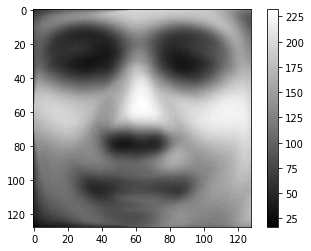

In [0]:
%%time 
path = "/content/PCA-Face/"
n_persons = 24
non_smiling = [f"{i+1:03}" for i in range(24)]
smiling = [f"{i+1:02}" for i in range(24)]
num2alpha = dict(zip(range(1, 27), string.ascii_uppercase))
names_list = num2alpha.values()
names_list = list(names_list)

labels = non_smiling.copy()
for i,v in enumerate(smiling):
  labels.insert(2*i+1,v)
noise_level = 0.1
h = 128 #min(min_dim_x,min_dim_y)
w = 128 #min(min_dim_x,min_dim_y)
redundency_per_image = 5
if(redundency_per_image != 0):
  val_idx = np.random.randint(redundency_per_image, size=len(labels))
val_images = np.zeros(h*w)
train_images = np.zeros(h*w)
q = train_images.shape[0]

for i in range(len(labels)): # 
  im = Image.open(path+"{}.tga".format(labels[i]))
  #im = get_aligned_img(im)
  im = np.array(im) 
#  im = cv2.equalizeHist(im)
#  im = hist_equalizer(im)
  im = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY) 
  temp = cv2.resize(im, (w,h), interpolation = cv2.INTER_AREA) 
  train_images = np.row_stack((train_images,cv2.equalizeHist(temp).ravel()))
  for j in range(2):
    for k in range(redundency_per_image):
      if(k == val_idx[i]):
        val_images = np.row_stack((val_images, generate_distorted_image(temp,h,w,j).ravel() ))
      else:
        train_images = np.row_stack((train_images, generate_distorted_image(temp,h,w,j).ravel() ))
  
train_images = train_images[1:]
val_images = val_images[1:]
print(train_images.shape)
print(val_images.shape)
num_faces_per_person = 2*(1+redundency_per_image*2)
Y_train = np.array([])
Y_val = np.array([])
if(redundency_per_image != 0):
  for i in range(n_persons):
    Y_train = np.append(Y_train, np.ones((num_faces_per_person-2*2))*(i+1))
    Y_val = np.append(Y_val, np.ones(2*2)*(i+1))
else:
  for i in range(n_persons):
    Y_train = np.append(Y_train, np.ones((num_faces_per_person))*(i+1))
print(Y_train.shape)
print(Y_val.shape)
mean_face = np.mean(train_images,axis=0)
plt.imshow(mean_face.reshape((h, w)), cmap=plt.cm.gray)
plt.colorbar()
plt.savefig('Output-images/mean_face.png')

# PCA

Variable Parameters:

1. n_components


In [0]:
n_components = train_images.shape[0]//8 # next 18

Y -> mean subtracted images

X_train -> Transformed data - PCA transformation

M -> Mean face

C -> Transformation matrix

All images are converted into linear 1D arrays

In [0]:
%%time
X_train, C, M, Y = pca(train_images, n_pc=n_components) # C -> (12,1444) X_train -> (48,12) M -> (1,1444) Y -> (48,1444)
eigenfaces = C.reshape((n_components, h, w)) # eigenfaces -> (50, 64, 64)
enc = OneHotEncoder()
Y_OH_train = enc.fit_transform(np.expand_dims(Y_train,1)).toarray()
if(Y_val.size != 0):
  Y_OH_val = enc.fit_transform(np.expand_dims(Y_val,1)).toarray()
  X_val = np.matmul(val_images-M,C.T)

(432, 54) (54,) (54, 16384)
(432, 432) (432,) (16384, 16384)
CPU times: user 1min 48s, sys: 3.48 s, total: 1min 51s
Wall time: 59.9 s


Eigen Faces (Number of components = 54)


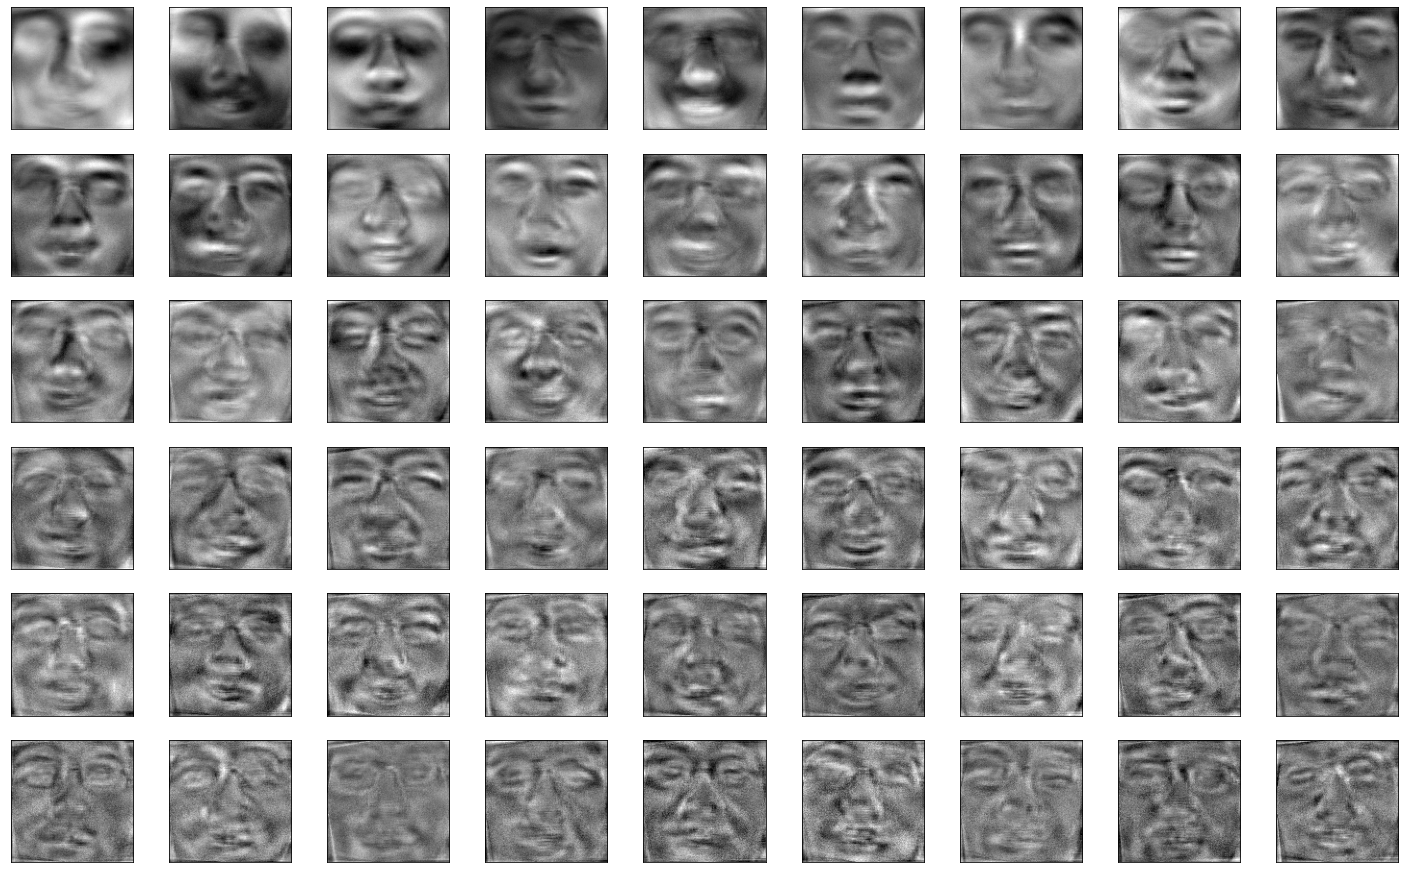

In [0]:
print("Eigen Faces (Number of components = {})".format(n_components))
plot_portraits(eigenfaces, h, w, 6, 9,save_fig=True,save_dir='Output-images/',save_name='Eigen_faces_54')

### Reconstructing training set images

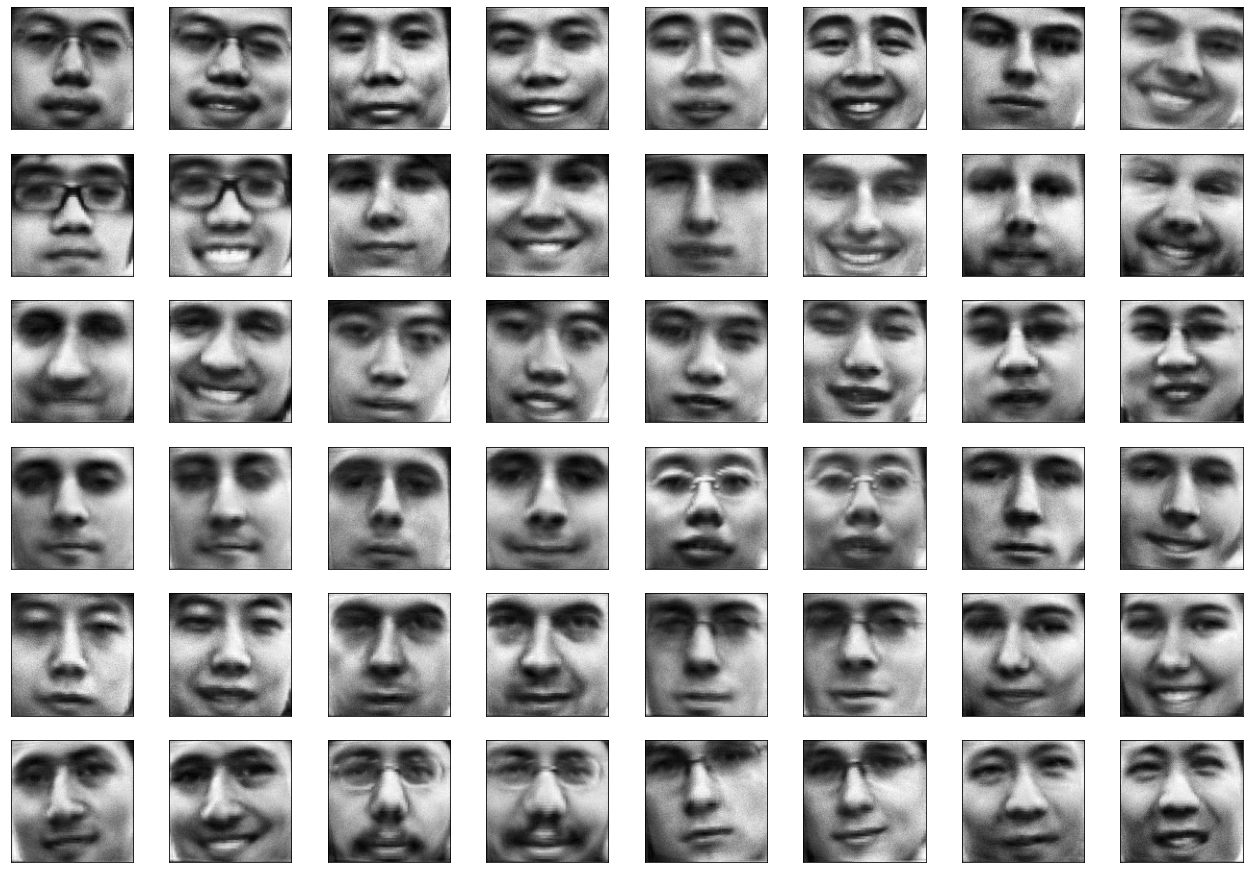

In [0]:
re_train_images=np.array([reconstruction(Y, C, M, h, w, i) for i in range(train_images.shape[0])])
plot_portraits(re_train_images[::9], h, w, 6, 8,save_fig=True,save_dir='Output-images/',save_name='Reconstructed_Training_samples')

### Reconstructing validation set images

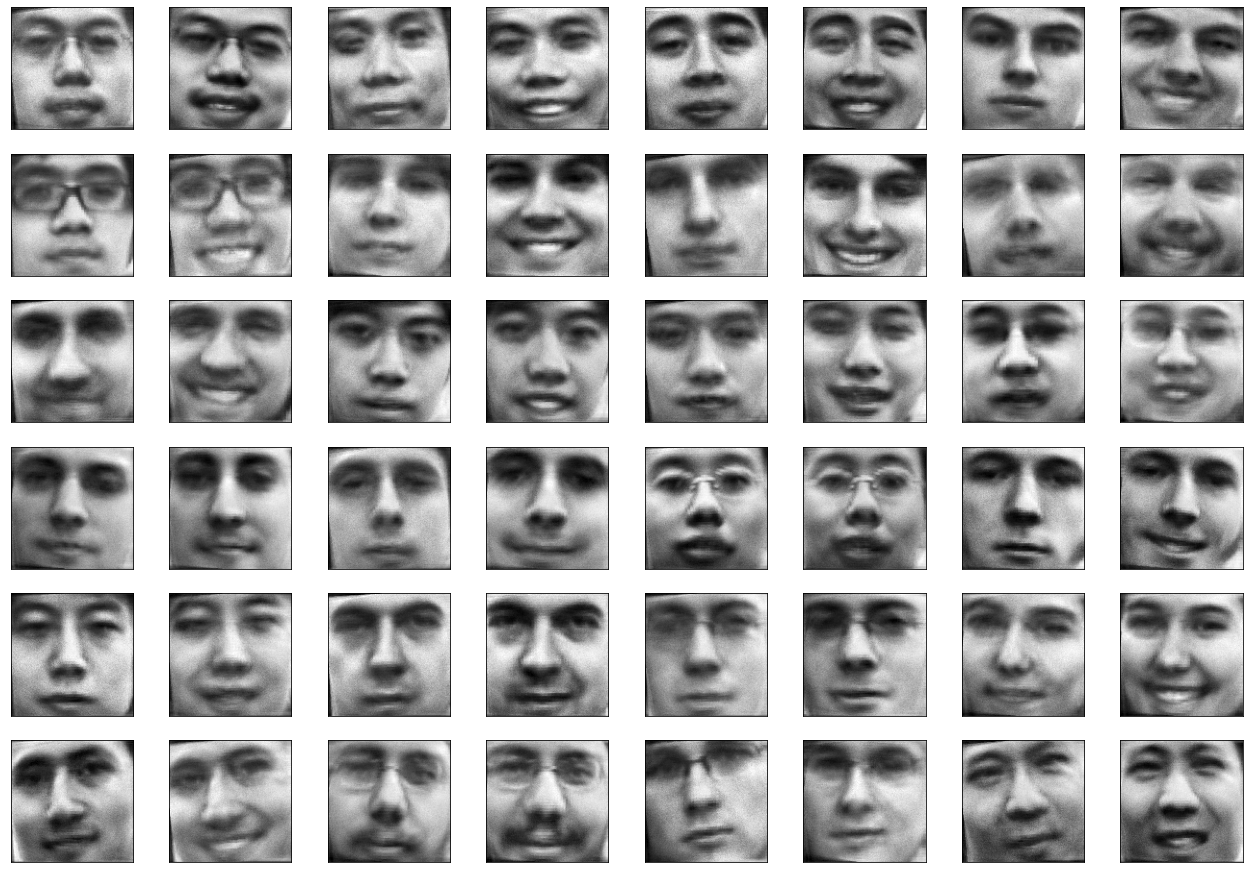

In [0]:
re_val_images = np.array([reconstruction(val_images-M, C, M, h, w, i) for i in range(val_images.shape[0])])
plot_portraits(re_val_images[::2], h, w, 6, 8,save_fig=True,save_dir='Output-images/',save_name='Reconstructed_Validation_samples')

# Using OpenCV's Pre-Trained Haar Classifier for face detection

(Justification: The face detection classifier, if to be designed and trained, requires thousands of images. As the large dataset is not available, we resort to using the pre-trained Haar-features based classifier by tuning the free-parameters)

In [0]:
!apt-get -qq install -y libsm6 libxext6

In [0]:
# running this cell once, produces error at first, so rerun the cell
!pip install -q -U opencv-python 


## Haar cascade files

OpenCV comes with a lot of pre-trained classsifiers. For instance there are classifiers for smile, eyes,face etc. These come in the form of xml files and are located in opencv/data/haarcascades/ folder. However, just to make things simple, you can also access them from here. Download the xml files and place them in data folder in the same working directory as the jupyter notebook.


### Loading the classifier for frontal face

In [0]:
haar_cascade_face = cv2.CascadeClassifier(path+'haarcascade_frontalface_alt.xml')


## Face detection

We shall be using the detectMultiscale module of the classifier.This function will return the co-ordinates(x and y posiiton plus the height and width) of the detected faces as Rect(x,y,w,h).

Found values of parameters: scaleFactor = 1.1 minNeighbors = 1 file used = "haarcascade_frontalface_alt.xml"

Then we loop over all the co-ordinates it returned and draw rectangles around them using Open CV.We will be drawing a green rectangle with thicknessof 2

Finally, we shall display the original image in coloured to see if the face has been detected correctly or not.

## Only for Visualizing Face Detection

Faces found:  12


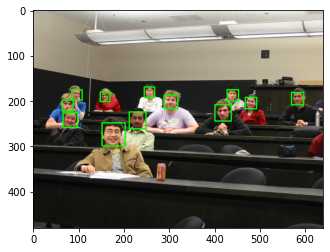

In [0]:
# Loading the image to be tested
test_image = Image.open(path+"IMG_0002.tga")
test_image = np.array(test_image) 

faces_rects = haar_cascade_face.detectMultiScale(test_image, scaleFactor = 1.1, minNeighbors = 1)
# Let us print the no. of faces found
#convert image to RGB and show image
print('Faces found: ', len(faces_rects))

for (x,y,w,h) in faces_rects:
     cv2.rectangle(test_image, (x, y), (x+w, y+h), (0, 255, 0), 2)

plt.imshow(test_image)

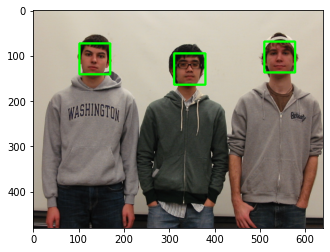

In [0]:
# Randomly plotting the test images -- showing succesful face detection

im = np.array(Image.open(path+"IMG_0005.tga"))
faces_rect = haar_cascade_face.detectMultiScale(im, scaleFactor=1.2, minNeighbors=5)

for (x, y, _w, _h) in faces_rect:
  cv2.rectangle(im,(x,y),(x+_w,y+_h),(0, 255, 0),4)
plt.imshow(im)


## Detecting and Extracting Faces from Test Images

In [0]:
n_test_imgs = 18
rare_people = ["bush_george_w_portrait.tga", "elf.png"] # Note: using png file for "elf" as the tga file showed OS error (?)
less_people = []
more_people = []
n_less_people = 16
n_more_people = 2
#h = 128
#w = 128
for i in range(n_less_people):
  less_people.append("IMG_0{}.tga".format(non_smiling[i+n_more_people])) 
for i in range(n_more_people):
  more_people.append("IMG_0{}.tga".format(non_smiling[i])) 

### Crop Dimensions Deciding 

Use these cells to decide the crop coordinates that makes the test images appear identical to training set images (best values found so far fed into test images generating function's default arguments)

In [0]:
i = 0
im = np.array(Image.open(path+"/IMG_0003.tga"))

faces_rect = haar_cascade_face.detectMultiScale(im, scaleFactor=1.2, minNeighbors=5)
temp0 = np.array([])
temp1 = np.array([])
temp2 = np.array([])
ctr = 0
w = 128
h = 128
for (x, y, _w, _h) in faces_rect:
  crop_im = im[y:y+_h, x:x+_w]
  crop_im = cv2.resize(crop_im, (w,h), interpolation = cv2.INTER_AREA)
  #crop_im = crop_im[crop_dims[0]:crop_dims[1],crop_dims[2]:crop_dims[3]]
  #crop_im = cv2.resize(crop_im, (w,h), interpolation = cv2.INTER_AREA)
  crop_im = hist_equalizer(crop_im)
  #crop_im = cv2.cvtColor(crop_im, cv2.COLOR_RGB2GRAY)
  if(ctr == 0):
    temp0 = np.array(crop_im)
  if(ctr == 1):
    temp1 = np.array(crop_im)
  if(ctr == 2):
    temp2 = np.array(crop_im)
  ctr +=1

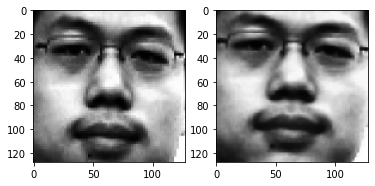

In [0]:
temp_img = hist_equalizer(cv2.resize(temp1[24:120,16:112], (w,h), interpolation = cv2.INTER_AREA))
temp_img = cv2.cvtColor(temp_img, cv2.COLOR_RGB2GRAY)
plt.subplot(1,2,1)
plt.imshow(train_images[0].reshape((h, w)), cmap=plt.cm.gray)
plt.subplot(1,2,2)
plt.imshow(temp_img , cmap=plt.cm.gray)
plt.savefig('Output-images/Training_image_vs_cropped_image.png')

### Generating Test Images

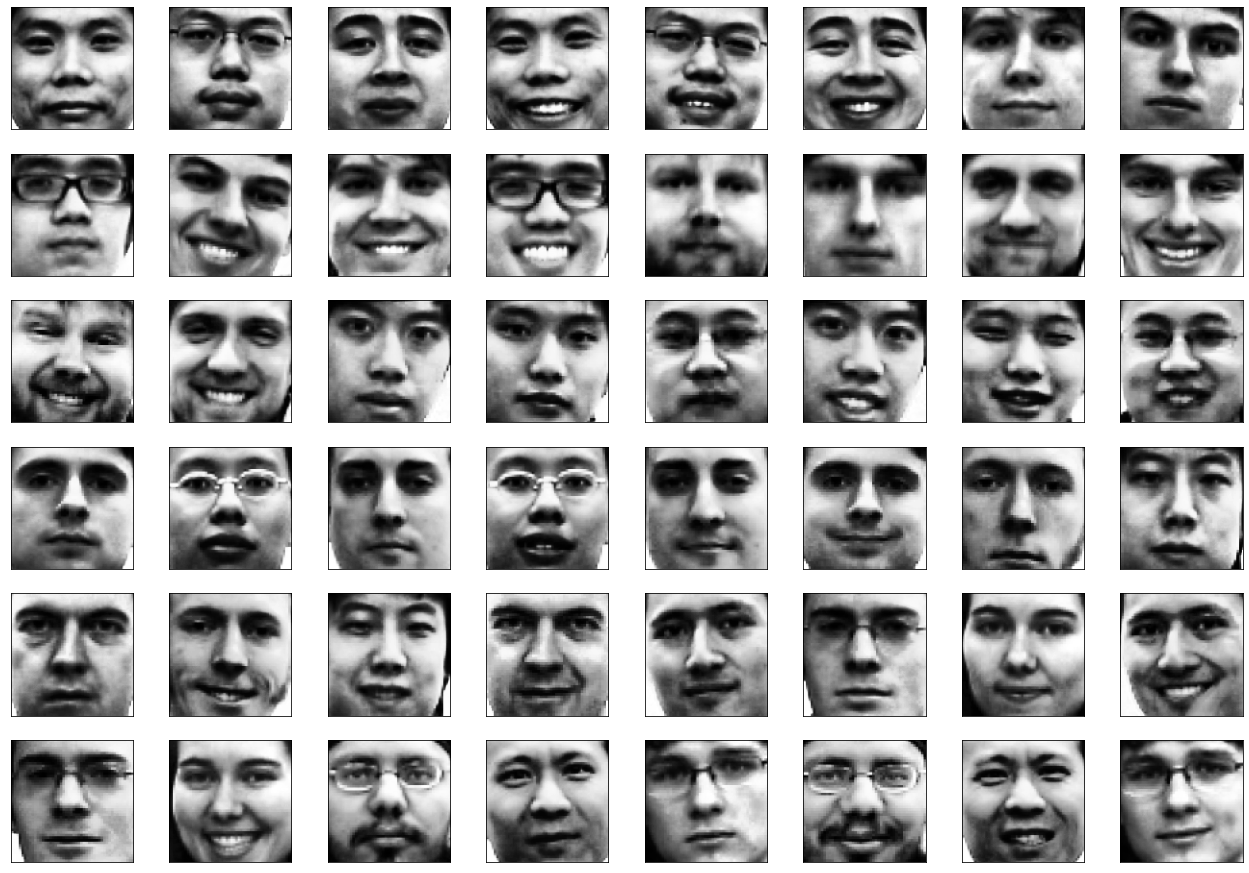

In [0]:
#test_images_r, test_images_g, test_images_b = get_cropped_faces(haar_cascade_face, test_file_names)
test_images = get_cropped_faces(haar_cascade_face, less_people,scaleFactor=1.2, minNeighbors=5,path=path)
# labels of the test images -- manually identified
Y_test = np.array([2,1,3,2,1,3,6,4,5,6,4,5,8,7,9,7,9,8,10,11,12,10,11,12,14,15,13,15,13,14,16,17,18,16,17,18,21,19,20,21,19,20,22,24,23,22,24,23])
Y_OH_test = enc.fit_transform(np.expand_dims(Y_test,1)).toarray()
X_test = np.matmul(test_images-M,C.T)
plot_portraits(test_images, h, w, 6, 8,save_fig=True,save_dir='Output-images/',save_name='Testing_samples')

### Reconstructing Test faces

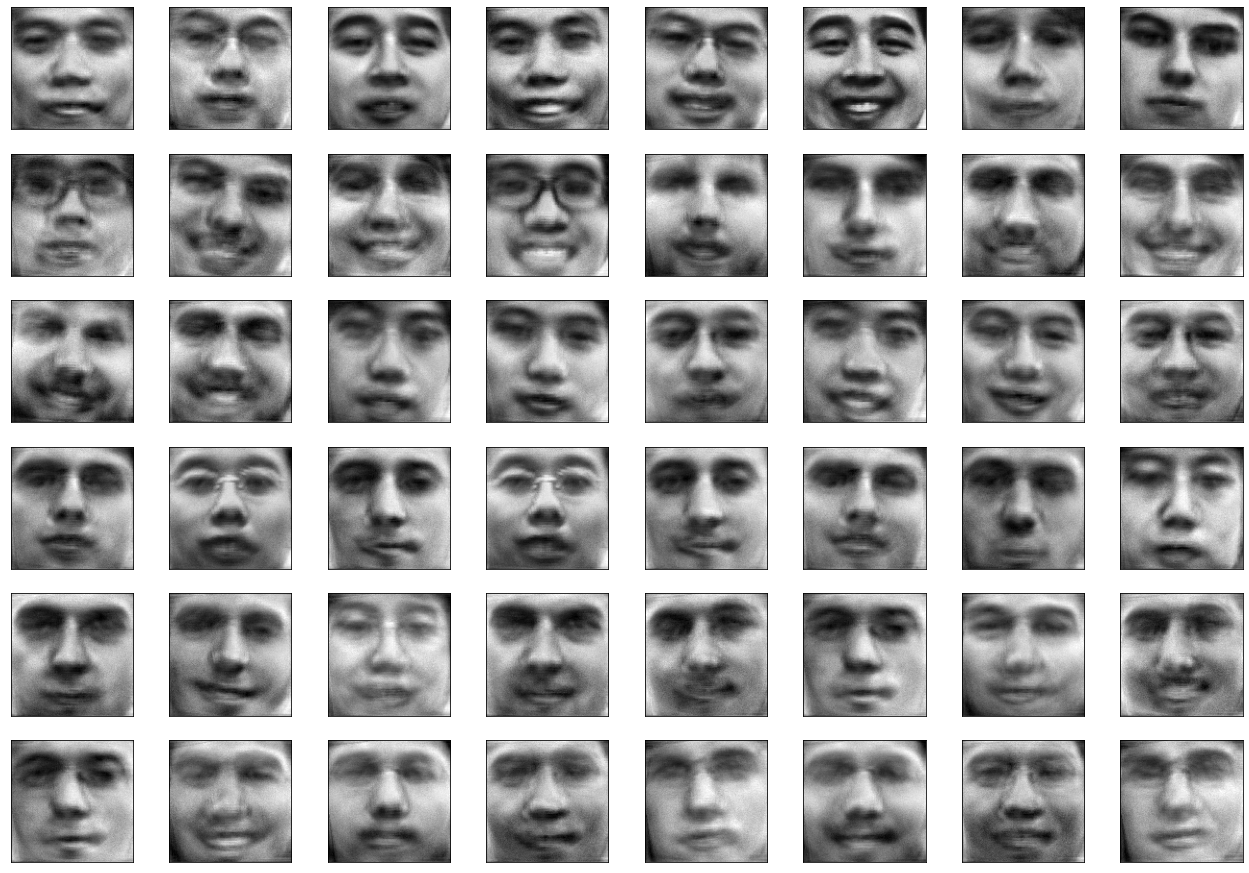

In [0]:
re_test_images=np.array([reconstruction(test_images-M, C, M, h, w, i) for i in range(test_images.shape[0])])
plot_portraits(re_test_images, h, w, 6, 8,save_fig=True,save_dir='Output-images/',save_name='Reconstructed_Testing_samples')

# k-NN Based Classification

1 70.83333333333334
2 41.66666666666667
3 41.66666666666667
4 22.916666666666664
5 18.75
Maximum accuracy obtained for k=1 : 70.83333333333334


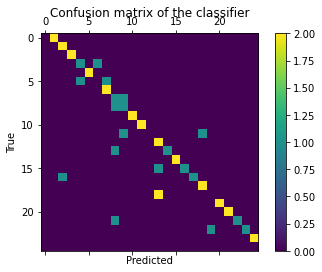

In [0]:
Y_pred_kNN, accuracy_kNN = run_kNN(X_train,X_test,Y_OH_train,Y_OH_test,save_fig=True)
#Y_pred_kNN, accuracy_kNN = run_kNN(X_train.to("cpu").detach().numpy(),X_test.to("cpu").detach().numpy(),Y_OH_train.to("cpu").detach().numpy(),Y_OH_test.to("cpu").detach().numpy())

# Support Vector Machine Based Classification

Training set score for SVM: 1.000000
Testing  set score for SVM: 0.791667
Best score for training data: 0.9930767174552259 

Best C: 10 

Best Kernel: rbf 

Best Gamma: 0.001 

[[2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


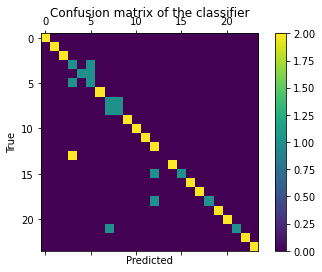

In [0]:
Y_pred_SVM, accuracy_SVM = run_SVM(X_train,X_test,Y_train,Y_test,print_details=True,save_fig=True)

# Porting to PyTorch

In [0]:
X_train, Y_OH_train, Y_train, X_val, Y_OH_val, Y_val, X_test, Y_OH_test, Y_test = map(torch.tensor, (X_train, Y_OH_train, Y_train, X_val, Y_OH_val, Y_val, X_test, Y_OH_test, Y_test))

X_train = X_train.float()
Y_train = Y_train.long()

X_val = X_val.float()
Y_val = Y_val.long()
X_test = X_test.float()
Y_test = Y_test.long()

# Training Neural Network on GPU

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Loss before training 3.2130001721991968
Loss after training 1.4142258352747183
Time for training model: 15.089s
Training Accuracy (top-1): 100.0
Testing Accuracy (top-1): 79.16666412353516


Training Accuracy (top-5): 100.0
Testing Accuracy (top-5): 89.58332824707031


Training Accuracy (top-10): 100.0
Testing Accuracy (top-10): 97.91666412353516




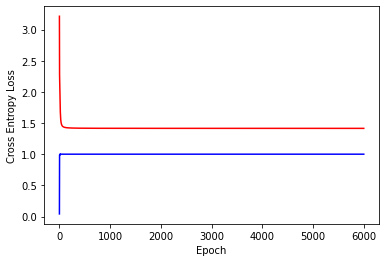

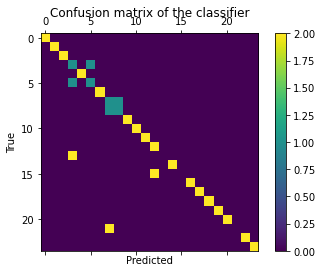

In [87]:
class RegularizedLinear(nn.Linear):
    def __init__(self, *args, ar_weight=1e-3, l1_weight=1e-3, l2_weight=2, **kwargs):
        super(RegularizedLinear, self).__init__(*args, **kwargs)
        #self.ar_weight = ar_weight
        #self.l1_weight = l1_weight
        self.l2_weight = l2_weight
        self._losses = {}

    def forward(self, input):
        output = super(RegularizedLinear, self).forward(input)
        #self._losses['activity_regularization'] = (output * output).sum() * self.ar_weight
        #self._losses['l1_weight_regularization'] = torch.abs(self.weight).sum() * self.l1_weight
        self._losses['l2_weight_regularization'] = torch.abs(torch.mul(self.weight,self.weight)).sum() * self.l2_weight
        return output

class FFNNetwork_Regularized(nn.Module):
  def __init__(self):
    super().__init__()
    torch.manual_seed(0)
    self.net = nn.Sequential(
        RegularizedLinear(n_components, 250), 
        nn.Tanh(),
        RegularizedLinear(250,150), 
        nn.Tanh(),
        RegularizedLinear(150, n_persons), 
        nn.Tanh(),   
        nn.Softmax()
    )

  def forward(self, X):
    return self.net(X)

  def softmax(self,x):
    return torch.exp(x)/torch.sum(torch.exp(x))

  def cross_entropy(self,pred,label):
    yl=torch.mul(pred,label)
    yl=yl[yl!=0]
    yl=-torch.log(yl)
    yl=torch.mean(yl)
    return yl

  def accuracy(self,y_hat, y):
    pred = torch.argmax(y_hat, dim=1)
    return (pred == torch.argmax(y, dim=1)).float().mean()

  def predict(self, X):
    Y_pred = self.forward(x)
    return np.array(Y_pred).squeeze()
  
  def accuracy_n(self,y_hat, y,topk=(1,)):
    maxk = max(topk)
    batch_size = y.size(0)

    _, pred = y_hat.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(torch.argmax(y, dim=1).view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
  
    return res

Y_pred_FFNN, accuracy_FFNN, model = run_FFNN(X_train,X_test,Y_OH_train,Y_OH_test,Epochs=6000,save_fig=True)

## Save Trained Model

In [0]:
torch.save(model.state_dict(),"/content/CLASS_FFNNetwork_Regularized.txt")

## Load Trained Model

In [0]:
model = FFNNetwork_Regularized()
model.load_state_dict(torch.load("/content/CLASS_FFNNetwork_Regularized.txt")) 
model.eval()

<All keys matched successfully>

In [0]:
model.accuracy_n(model.forward(X_test),Y_OH_test, topk=(1,))[0].item()

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


81.25

# ENSEMBLE CLASSIFIER

Vote weighted according to individual classifier accuracy score on test data

In [0]:
# As the FFNN outputs are torch tensors and on GPU, need to convert to numpy array and port to CPU
Y_pred_FFNN = Y_pred_FFNN.to("cpu").detach().numpy()
Y_pred_FFNN = np.argmax(Y_pred_FFNN,axis=1)
Y_pred_FFNN += 1

Testing Accuracy (top-1): 81.25
Testing Accuracy (top-5): 89.58332824707031
Testing Accuracy (top-10): 89.58332824707031


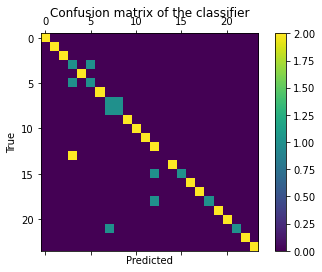

In [0]:
Y_OH_kNN = enc.fit_transform(np.expand_dims(np.append(Y_pred_kNN,np.arange(n_persons+1)[1:]),1)).toarray()[0:Y_pred_kNN.size]
Y_OH_SVM = enc.fit_transform(np.expand_dims(np.append(Y_pred_SVM,np.arange(n_persons+1)[1:]),1)).toarray()[0:Y_pred_SVM.size]
Y_OH_FFNN = enc.fit_transform(np.expand_dims(np.append(Y_pred_FFNN,np.arange(n_persons+1)[1:]),1)).toarray()[0:Y_pred_FFNN.size]
save_fig = True
save_dir = "Output-files/"
save_name = "Confusion_matrix_ensemble"
weightage = [accuracy_kNN,accuracy_SVM,accuracy_FFNN]
weightage /= sum(weightage)
temp_Y_pred_ensemble = weightage[0]*Y_OH_kNN + weightage[1]*Y_OH_SVM + weightage[2]*Y_OH_FFNN 
Y_pred_ensemble = np.argmax(weightage[0]*Y_OH_kNN + weightage[1]*Y_OH_SVM + weightage[2]*Y_OH_FFNN , axis=1)
Y_pred_ensemble += 1  
cm = confusion_matrix(Y_test, Y_pred_ensemble)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
if(save_fig):
  plt.savefig(save_dir+save_name+"_(kNN_SVM_FFNN).png")
else:
  plt.show()

for k in [1,5,10]:
  accuracy_test = accuracy_n(torch.tensor(temp_Y_pred_ensemble),Y_OH_test, topk=(k,))[0].item()
  print('Testing Accuracy (top-{}): {}'.format(k,accuracy_test))


# Downloading All Saved Plots


In [0]:
!zip -r /content/Output-images.zip


zip error: Nothing to do! (/content/Output-images.zip)


In [0]:
files.download("/content/Output-images.zip")

MessageError: ignored